# 均值方差投资组合的改进

### 矩阵和方差的估计

+ 在均值方差投资组合模型中，大家发现对于中高频数据，估计均值比估计方差更困难。著名的 **Black-Litterman** (1992) 投资投资组合选择模型力图提供解决该问题的方案。 

+ 我们将要描述的**稳健投资组合选择**也是基于此出发点发展起来的。

+ 我们首先介绍BL模型，改进均值方差投资组合模型，然后根据分析验证均值估计的难度。　

我们将介绍和回顾如下内容：　

- 均值方差投资组合理论
- 线性回归的贝叶斯方法
- 风险敏感算子及其和稳健控制理论的关系 

　

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as stat
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, FloatSlider

### 均值方差投资组合, 带风险厌恶参数的形式

这里我们用另一种方式介绍均值方差组合。首先介绍记号：

+ 单期无风险收益率 $ r_f $.

+ 一个 $ n \times 1 $ 向量$\vec r$，表示风险资产的收益率，而
  $ \vec r - r_f {\bf 1} $ 表示**超额收益率**,其中   $ {\bf 1} $  表示 $ n \times 1 $个1构成的向量。

超额收益向量满足均值为 $ \mu $，协方差为
  $ \Sigma $的**正态分布** ，表示为：
$$
\vec r - r_f {\bf 1} \sim {\mathcal N}(\mu, \Sigma)
$$

或者
$$
\vec r - r_f {\bf 1} = \mu + C \epsilon
$$

其中  $ \epsilon \sim {\mathcal N}(0, I) $是$ n \times 1 $标准正态随机向量.

记 $ w $ 为 $ n \times 1 $ 投资权重向量.

则投资组合 $ w $ 的收益率分布满足

$$
w' (\vec r - r_f {\bf 1}) \sim {\mathcal N}(w' \mu, w' \Sigma w )
$$

+  **均值方差投资组合问题** 是选择$ w $ 以极大化


<a id='equation-choice-problem'></a>
$$
U(\mu,\Sigma;w) = w'\mu - \frac{\delta}{2} w' \Sigma w \tag{1}
$$

其中 $ \delta > 0 $ 是风险厌恶参数，极大化 (1)的一阶条件为 

$$
\mu = \delta \Sigma w
$$

风险资产组合权重


<a id='equation-risky-portfolio'></a>
$$
w = (\delta \Sigma)^{-1} \mu \tag{2}
$$

这和我们的切线组合类似，$\delta$决定了投资于风险资产的比例。

###  均值和方差的估计

投资组合模型(2)需要输入的两个量包括

-  参数 $ \mu, \Sigma $,其决定超额收益率$ (\vec r - r_f {\bf 1}) $的分布
-  风险厌恶系数 $ \delta $  


估计  $ \mu $ 的标准方法是极大似然估计或者最小二乘估计,在正态假设下，就是样本均值和样本协方差。 

###  Why BL 模型

从历史数据估计  $ \mu $ 和 $ \Sigma $并结合 **合理的** 风险厌恶参数,式 (2)通常给出极端的多空头寸( **extreme long and short positions**).

投资组合的管理者显然不可能将这种组合推荐给顾客。 

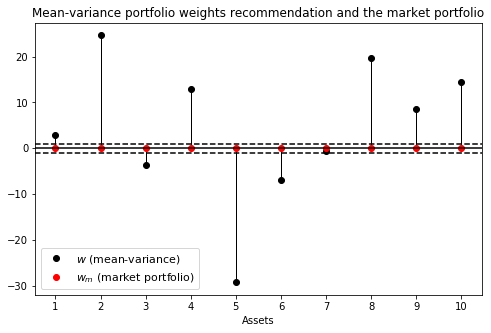

In [7]:
#np.random.seed(12)
 
N = 10   #资产数量                                       
T = 200  #样本量                                      

# 随机的市场组合，
#市场组合是资产按市值比例构成的组合，即投资者群体作为一个整体持有的组合
w_m = np.random.rand(N)
w_m = w_m / (w_m.sum())


mu = (np.random.randn(N) + 5)  /100      # 平均超额收益
S = np.random.randn(N, N)        # 生成一个随机矩阵
V = S @ S.T           # 构造对称的协方差矩阵
#  调整使得sharp比为1，这些设定让市场组合看起来合理。
Sigma = V * (w_m @ mu)**2 / (w_m @ V @ w_m)

# 风险厌恶参数 
delta = 1 / np.sqrt(w_m @ Sigma @ w_m)

# 生成样本超额收益率
excess_return = stat.multivariate_normal(mu, Sigma)
sample = excess_return.rvs(T)

# Estimate μ and Σ
mu_est = sample.mean(0).reshape(N, 1)
Sigma_est = np.cov(sample.T)

w = np.linalg.solve(delta * Sigma_est, mu_est)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Mean-variance portfolio weights recommendation and the market portfolio')
ax.plot(np.arange(N)+1, w, 'o', c='k', label='$w$ (mean-variance)')
ax.plot(np.arange(N)+1, w_m, 'o', c='r', label='$w_m$ (market portfolio)')
ax.vlines(np.arange(N)+1, 0, w, lw=1)
ax.vlines(np.arange(N)+1, 0, w_m, lw=1)
ax.axhline(0, c='k')
ax.axhline(-1, c='k', ls='--')
ax.axhline(1, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
plt.legend(numpoints=1, fontsize=11)
plt.show()

Black and Litterman 对这种情况如下处理:

- 接受(2) 确定最优投资组合的最优权重$ w $.  
- 继续使用 $ \delta $表示投资者的风险厌恶 
- 使用 $ \Sigma $的极大似然估计值，单改变 
  $ \mu $,使得优化的结果贴近市场组合（可以理解为大多数投资组合并持有的组合）。  


解法如下， 使用市场的$ \Sigma $，选择一个合理的 $ \delta $, 反解超额收益
$ \mu_{BL} $ 使得(2)式确定的 $ w $ 正好等于 **实际的** 市场组合
$ w_m $, 

$$
w_m = (\delta \Sigma)^{-1} \mu_{BL}
$$

这个
$ \mu_{BL} $ 理解为市场观点。

### 细节,如何求$\delta$

定义

$$
w_m' \mu \equiv ( r_m - r_f)
$$

为市场组合$w_m$的超额收益.

定义市场组合$ w_m $超额收益的方差 
$$
\sigma^2 = w_m' \Sigma w_m
$$


定义市场组合**Sharpe-ratio**
$$
{\bf SR}_m = \frac{ r_m - r_f}{\sigma}
$$
 
由一阶条件
$$
w_m'\mu = \delta w_m'\Sigma w_m
$$
  
 得
$ r_m - r_f = \delta_m \sigma^2 $ or

$$
\delta_m = \frac{r_m - r_f}{\sigma^2}
$$

or

$$
\delta_m = \frac{{\bf SR}_m}{\sigma}
$$

这样第一步中，我们通过估计${\bf SR}$，$\sigma$得到 $\delta_m$的估计。


第二步中，我们利用$ \delta_m $，以及 
$ \Sigma $的极大似然估计，通过(2)推导  $ \mu_{\bf BL} $  

$$
\mu_m = \delta_m \Sigma w_m
$$

到这一步， Black-Litterman portfolio模型得出  $ (\delta_m, \mu_m) $，告诉投资者持有市场组合。 

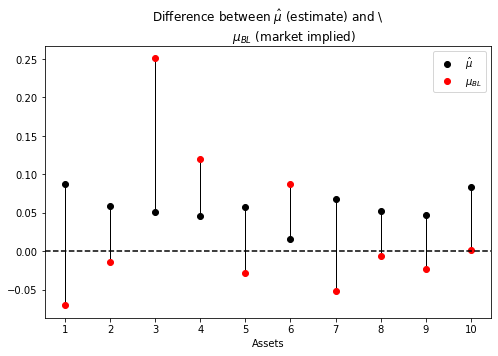

In [9]:
# Observed mean excess market return
r_m = w_m @ mu_est

# Estimated variance of the market portfolio
sigma_m = w_m @ Sigma_est @ w_m

# Sharpe-ratio
sr_m = r_m / np.sqrt(sigma_m)

# Risk aversion of market portfolio holder
d_m = r_m / sigma_m

# Derive "view" which would induce the market portfolio
mu_m = (d_m * Sigma_est @ w_m).reshape(N, 1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title(r'Difference between $\hat{\mu}$ (estimate) and \
              $\mu_{BL}$ (market implied)')
ax.plot(np.arange(N)+1, mu_est, 'o', c='k', label='$\hat{\mu}$')
ax.plot(np.arange(N)+1, mu_m, 'o', c='r', label='$\mu_{BL}$')
ax.vlines(np.arange(N) + 1, mu_m, mu_est, lw=1)
ax.axhline(0, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
plt.legend(numpoints=1)
plt.show()

###  增加"观点"

+ Black and Litterman 设定了一个基准投资者，其具有市场观点**market’s views**，认为超额收益率满足如下： 
<a id='equation-excess-returns'></a>
$$
\vec r - r_f {\bf 1} \sim {\mathcal N}( \mu_{BL}, \Sigma) \tag{3}
$$
按照模型，基准投资者持有市场组合。

+ Black and Litterman 模型然后假设投资者可能具有和“市场观点”不一致的观点。  投资者希望恰当地融合自己的观点和市场观点进行投资组合选择。　

+ 假设投资者的观点和(3)不同, 超额收益率如下表示：
$$
\vec r - r_f {\bf 1} \sim {\mathcal N}( \hat \mu, \tau \Sigma)
$$
 其中参数 $ \tau > 0 $确定投资者如何将其自身观点$ \hat \mu $ 和市场观点$ \mu_{\bf BL} $进行融合。$\tau$越大,自身观点越不确定,在融合中的权重就应该越低.

+  Black and Litterman利用如下公式进行观点
$ \hat \mu $ and $ \mu_{\bf BL} $的融合，得到新的超额收益率。


<a id='equation-mix-views'></a>
$$
\tilde \mu = (\Sigma^{-1} + (\tau \Sigma)^{-1})^{-1} (\Sigma^{-1} \mu_{BL}  + (\tau \Sigma)^{-1} \hat \mu) \tag{4}
$$

+ 　而最终推荐的投资组合则由下式给出。
$$
\tilde w = (\delta \Sigma)^{-1} \tilde \mu
$$
组合 $ \tilde w $偏离$ w_{BL} $的程度依赖参数$ \tau $. 

In [10]:
def black_litterman(la , mu1, mu2, Sigma1, Sigma2):
    """
    This function calculates the Black-Litterman mixture
    mean excess return and covariance matrix
    """
    Sigma1_inv = np.linalg.inv(Sigma1)
    Sigma2_inv = np.linalg.inv(Sigma2)

    mu_tilde = np.linalg.solve(Sigma1_inv + la * Sigma2_inv,
                              Sigma1_inv @ mu1 + la * Sigma2_inv @ mu2)
    return mu_tilde

tau = 1
mu_tilde = black_litterman(1, mu_m, mu_est, Sigma_est, tau * Sigma_est)

# The Black-Litterman recommendation for the portfolio weights
w_tilde = np.linalg.solve(delta * Sigma_est, mu_tilde)

tau_slider = FloatSlider(min=0.05, max=10, step=0.5, value=tau)

@interact(tau=tau_slider)
def BL_plot(tau):
    mu_tilde = black_litterman(1, mu_m, mu_est, Sigma_est, tau * Sigma_est)
    w_tilde = np.linalg.solve(delta * Sigma_est, mu_tilde)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(N)+1, mu_est, 'o', c='k',
               label=r'$\hat{\mu}$ (subj view)')
    ax[0].plot(np.arange(N)+1, mu_m, 'o', c='r',
               label=r'$\mu_{BL}$ (market)')
    ax[0].plot(np.arange(N)+1, mu_tilde, 'o', c='y',
               label=r'$\tilde{\mu}$ (mixture)')
    ax[0].vlines(np.arange(N)+1, mu_m, mu_est, lw=1)
    ax[0].axhline(0, c='k', ls='--')
    ax[0].set(xlim=(0, N+1), xlabel='Assets',
              title=r'Relationship between $\hat{\mu}$, \
                      $\mu_{BL}$and$\tilde{\mu}$')
    ax[0].xaxis.set_ticks(np.arange(1, N+1, 1))
    ax[0].legend(numpoints=1)

    ax[1].set_title('Black-Litterman portfolio weight recommendation')
    ax[1].plot(np.arange(N)+1, w, 'o', c='k', label=r'$w$ (mean-variance)')
    ax[1].plot(np.arange(N)+1, w_m, 'o', c='r', label=r'$w_{m}$ (market, BL)')
    ax[1].plot(np.arange(N)+1, w_tilde, 'o', c='y',
               label=r'$\tilde{w}$ (mixture)')
    ax[1].vlines(np.arange(N)+1, 0, w, lw=1)
    ax[1].vlines(np.arange(N)+1, 0, w_m, lw=1)
    ax[1].axhline(0, c='k')
    ax[1].axhline(-1, c='k', ls='--')
    ax[1].axhline(1, c='k', ls='--')
    ax[1].set(xlim=(0, N+1), xlabel='Assets',
              title='Black-Litterman portfolio weight recommendation')
    ax[1].xaxis.set_ticks(np.arange(1, N+1, 1))
    ax[1].legend(numpoints=1)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='tau', max=10.0, min=0.05, step=0.5), Output()), _dom…